# CNN From Ch.12 using ShallowNet

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

# checks to see if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("CUDA Available: ", torch.cuda.is_available())
print(torch.version.cuda)

CUDA Available:  True
12.1


## ShallowNet Model
Simple CNN, using 1 convolutional layer that contains 32 filters with a 3x3 kernel

In [2]:
# ShallowNet model
class ShallowNet(nn.Module):
    def __init__(self):
        super(ShallowNet, self).__init__()
        
        # only convolution layer
        # 1 channel, so no RGB
        # output: 32 feature maps
        # kernel: 3x3
        # padding 1: so kernel doesn't go off the edge
        self.conv1 = nn.Conv2d(1, 32, kernel_size = 3, padding=1)

        # activation for non-linearity (more complex patterns)
        self.relu = nn.ReLU()

        # flatten layer, converts feature maps into 1d vectors
        self.flatten = nn.Flatten()

        # FC layer
        # input size: 32 by 28 by 28 since MNIST is 28x28
        # output: 10 (1 neuron per digit class 0-9)
        self.fc = nn.Linear(32 * 28 * 28, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.flatten(x)
        x = self.fc(x)
        return x

## Dataset
MNIST, contains handwritten digits 0-9

In [3]:
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transform, download=True)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

print("Train: ", len(train_dataset))
print("Test:  ", len(test_dataset))

Train:  60000
Test:   10000


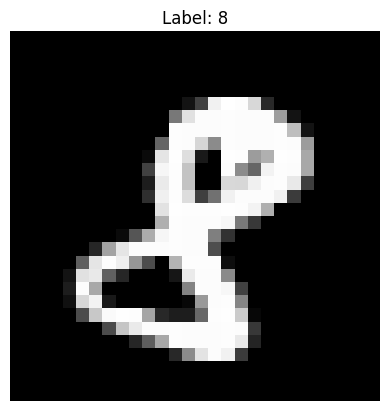

In [11]:
# ChatGPT code to display a sample from the dataset
sample_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1, shuffle=True)
sample_image, sample_label = next(iter(sample_loader))
sample_image_np = sample_image.squeeze().numpy()  
plt.imshow(sample_image_np, cmap="gray")
plt.title(f"Label: {sample_label.item()}")
plt.axis("off")
plt.show()

## Model Training

In [5]:
# training params
# num times the dataset will be passed through the network
num_epochs = 5

# model initialization
model = ShallowNet().to(device)

# loss function and optimizer
criterion = nn.CrossEntropyLoss() 
optimizer = optim.SGD(model.parameters(), lr=0.01)

# lists to store training and testing loss/accuracy
train_losses, test_losses = [], []
train_acc, test_acc = [], []

Epoch [1/5], Train Loss: 0.4038, Train Acc: 88.37%, Test Acc: 92.17%
Epoch [2/5], Train Loss: 0.2675, Train Acc: 92.38%, Test Acc: 93.30%
Epoch [3/5], Train Loss: 0.2243, Train Acc: 93.67%, Test Acc: 94.21%
Epoch [4/5], Train Loss: 0.1850, Train Acc: 94.86%, Test Acc: 95.67%
Epoch [5/5], Train Loss: 0.1532, Train Acc: 95.80%, Test Acc: 96.22%


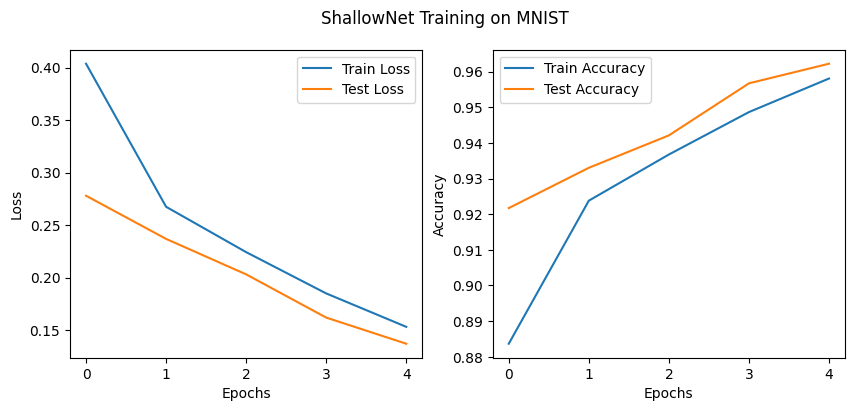

In [6]:
# training loop
for epoch in range(num_epochs):
    model.train() # puts model in training mode
    correct, total, epoch_loss = 0,0,0

    # iterate through dataset in batches
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device) # moves to GPU
        optimizer.zero_grad() # zero gradients to prevent accumulation
        outputs = model(images) # forward pass, predictions
        loss = criterion(outputs, labels) # computes loss between predictions and true
        loss.backward() # backward pass
        optimizer.step() # update params

        # track loss and accuracy
        epoch_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_losses.append(epoch_loss/len(train_loader))
    train_acc.append(correct/total)

    # evaluate model on test
    model.eval()
    correct, total, test_loss = 0,0,0

    # Disable gradient computation
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    #store test loss and accuracy
    test_losses.append(test_loss / len(test_loader))
    test_acc.append(correct / total)
            
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, "
          f"Train Acc: {train_acc[-1]*100:.2f}%, Test Acc: {test_acc[-1]*100:.2f}%")
    
# Plot training history
plt.figure(figsize=(10, 4))

# Plot loss over epochs
plt.subplot(1, 2, 1)
plt.plot(range(num_epochs), train_losses, label="Train Loss")
plt.plot(range(num_epochs), test_losses, label="Test Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

# Plot accuracy over epochs
plt.subplot(1, 2, 2)
plt.plot(range(num_epochs), train_acc, label="Train Accuracy")
plt.plot(range(num_epochs), test_acc, label="Test Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.suptitle("ShallowNet Training on MNIST")
plt.show()    
        